📦 Use Case: Estimating Revenue Per User (RPU) with Bootstrapping
📘 Scenario:
You run an experiment to test a new pricing layout on Adobe's website.

Group A (Control) sees the old layout.

Group B (Treatment) sees the new layout.

You want to compare Revenue Per User (RPU) — a common metric that captures both conversion rate and purchase value.

⚠️ Problem:
RPU is highly skewed: most users generate $0, a few generate $100+.

The data violates assumptions of normality → traditional t-tests may mislead.

You want a robust estimate of the difference and uncertainty around it.

🎯 Objective:
Compare mean RPU between groups.

Use bootstrapping to:

Estimate the 95% confidence interval of the difference.

Check for statistical significance.

Understand risk: what's the chance the new layout performs worse?



In [6]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read data 
data = pd.read_csv('Synthetic_RPU_Data.csv')

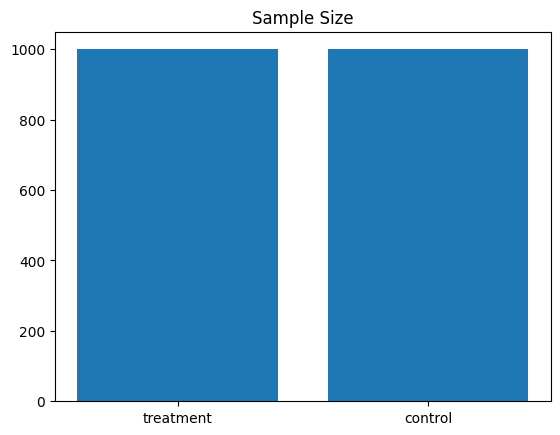

In [77]:
# Samples 
plt.bar(
    ['treatment', 'control'],
    [len(data[data.group == 'treatment']), len(data[data.group == 'control'])]
    )
plt.title('Sample Size')
plt.show()

Total RPU for control group: 4896.153482605907
Total RPU for treatment group: 8367.347108508322
Observed Uplifit: 70.90


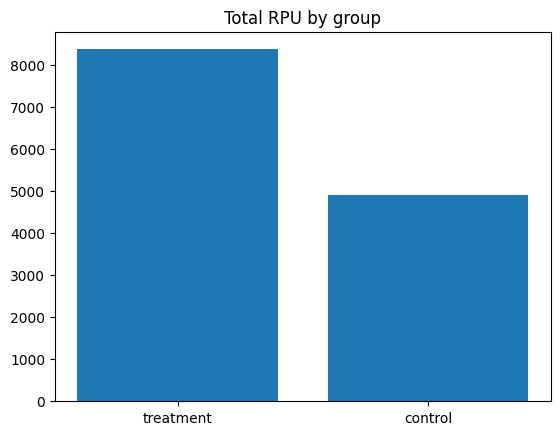

In [31]:
# Total RPU by group 
control_rpu = data[data.group == 'control'].rpu.sum()
treatment_rpu = data[data.group == 'treatment'].rpu.sum()
print(f'Total RPU for control group: {control_rpu}')
print(f'Total RPU for treatment group: {treatment_rpu}')
print(f'Observed Uplifit: {(treatment_rpu - control_rpu) / control_rpu * 100:.2f}')
plt.bar(
    ['treatment', 'control'],
    [treatment_rpu, control_rpu]
    )
plt.title('Total RPU by group')
plt.show()

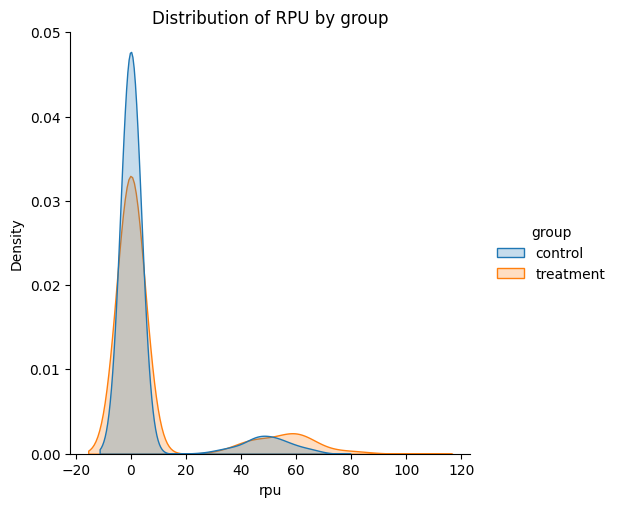

In [51]:
sns.displot(data = data , x = 'rpu', hue = 'group', kind = 'kde', fill = True)
plt.title('Distribution of RPU by group')
plt.show()

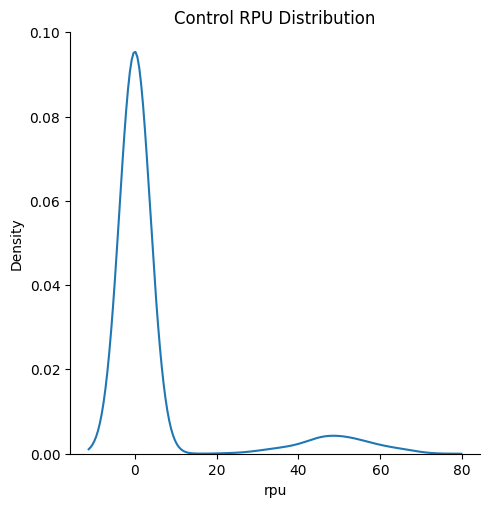

In [42]:
# Distributions 
sns.displot(data[data.group == 'control'].rpu, label='control', kind='kde')
plt.title('Control RPU Distribution')
plt.show()

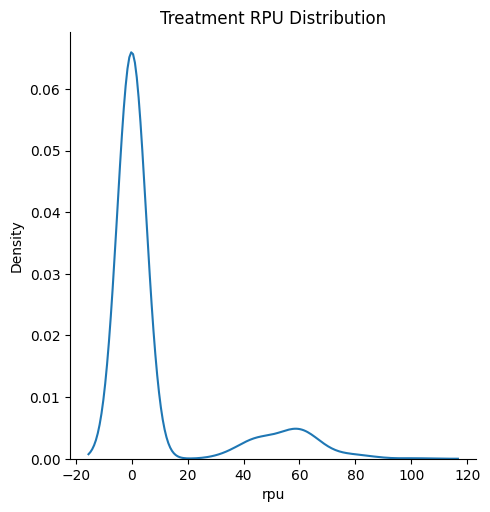

In [41]:
# Distributions 
sns.displot(data[data.group == 'treatment'].rpu, label='treatment', kind='kde')
plt.title('Treatment RPU Distribution')
plt.show()

In [49]:
# Describe 
print(f"Control distribution {data[data.group == 'control'].rpu.describe()}\n")
print(f"Treatment distribution {data[data.group == 'treatment'].rpu.describe()}\n")

Control distribution count    1000.000000
mean        4.896153
std        14.971314
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        68.522782
Name: rpu, dtype: float64

Treatment distribution count    1000.000000
mean        8.367347
std        20.460065
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       101.232778
Name: rpu, dtype: float64



In [52]:
# The data is positively skewed. Using bootstrapping to estimate the mean and confidence intervals as it is more robust to non-normality.
# 1. Simulate 10.000 samples of size 100 with replacement
# 2. collect mean uplifts 
# 3. calculate the mean and 95% confidence intervals

In [56]:
# 1. Sampling 
differences = []
control_rpu = data[data.group == 'control'].rpu
treatment_rpu = data[data.group == 'treatment'].rpu
for _ in range(10000): 
    control_sample = np.random.choice(control_rpu, size = len(control_rpu), replace = True)
    treatment_sample = np.random.choice(treatment_rpu, size = len(treatment_rpu), replace = True)
    # 2. collect mean uplifts 
    differences.append(treatment_sample.mean() - control_sample.mean())


count    10000.000000
mean         3.471400
std          0.793643
min          0.495057
25%          2.928801
50%          3.471210
75%          4.010735
max          6.427986
dtype: float64


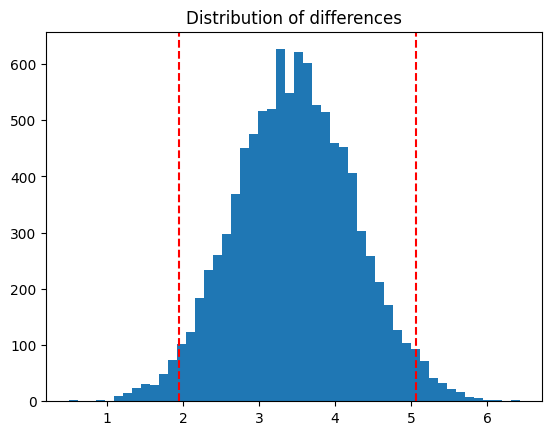

95% confidence interval: 1.94 - 5.07


In [65]:
# Plot differences distribution 
print(pd.Series(differences).describe())

ci_lower = np.percentile(differences, 2.5)
ci_upper = np.percentile(differences, 97.5)

plt.hist(differences, bins=50)
plt.axvline(ci_lower, color='red', linestyle='--')
plt.axvline(ci_upper, color='red', linestyle='--')
plt.title('Distribution of differences')
plt.show()

print(f"95% confidence interval: {ci_lower:.2f} - {ci_upper:.2f}")


In [ ]:
# If we repeated this experiment many times with samples of the same size, the true difference in mean RPU would fall between $1.90 and $5.10 in 95% of those cases.
# Because 0 is not in the confidence interval we can reject the null hypothesis and conclude that there is a statistical significance between the groups 
# The risk of making a type I error is 5%

In [ ]:
# Uplift

obs_diff = treatment_rpu.mean() - control_rpu.mean()
pct_uplift = (obs_diff / control_rpu.mean()) * 100
print(f"Observed difference: {obs_diff:.2f}")

Observed difference: 3.47


In [82]:
# Risk 
risk_of_loss = (np.array(differences) < 0).mean()
print(f"Risk of loss: {risk_of_loss:.2f}")

Risk of loss: 0.00
